# preprocessing
- find null values
- replace with feature mean
- find outliers (especially m2)
- enumarate categorical features
- drop title col
- drop id col
- convert all prices to try
- drop lat lon
- convert date values to be of the same race
- drop type (bcz all values are flat)
- drop currency
- remove outlier prices (25000 TL, 8500000TL)

In [215]:
import polars as pl
import matplotlib.pyplot as plt

In [216]:
df = pl.read_csv("real_estate_data.csv", null_values=["Unknown", "None"])
df.head()

title,Id,price,currency,loc city,loc county,loc dist,lat,lon,date,type,m2,rooms,age,floor,tfloor,heat,bath,furn,status,resid,due,loan,saler,exc
str,i64,i64,str,str,str,str,f64,f64,str,str,i64,str,str,str,str,str,str,bool,str,str,i64,bool,str,str
"""SAHİBİNDEN-%10…",323589399,225000,"""Turkish Lira""","""İstanbul""","""Sancaktepe""","""Sarıgazi Mah.""",41.003838,29.213019,"""28 Temmuz 2016…","""Flat""",85,"""2+1""","""5-10""","""High Entrance""","""5""","""Combi""","""1""",false,"""Tenant""","""False.1""",0,true,"""Owner""","""True.1"""
"""İSTANBULUN MER…",323599659,360000,"""Turkish Lira""","""İstanbul""","""Üsküdar""","""Ünalan Mah.""",41.005051,29.062934,"""28 Temmuz 2016…","""Flat""",87,"""2+1""","""0""","""Ground Floor""","""9""","""Combi""","""1""",false,"""Empty""","""True""",null,true,"""Owner""","""False"""
"""Merkezde 4+1 Ş…",323536105,335000,"""Turkish Lira""","""İstanbul""","""Arnavutköy""","""Hastane Mah.""",41.15349,28.619143,"""27 Temmuz 2016…","""Flat""",160,"""4+1""","""0""","""4""","""5""","""Combi""","""1""",false,"""Empty""","""True""",null,true,"""Owner""","""False"""
"""kelepir büyük …",323709392,235000,"""Turkish Lira""","""Antalya""","""Muratpaşa""","""Yenigün Mah.""",36.902681,30.721658,"""28 Temmuz 2016…","""Flat""",165,"""4+1""","""5-10""","""Rise 4""","""4""","""Floor Calorie""","""2""",false,"""Tenant""","""False""",25,true,"""Owner""","""True"""
"""ACİL SAHİBİNDE…",323730617,229000,"""Turkish Lira""","""Manisa""","""Yunusemre""","""Muradiye""",38.638822,27.346087,"""28 Temmuz 2016…","""Flat""",208,"""5+1""","""0""","""Rise 4""","""5""","""Combi""","""2""",false,"""Tenant""","""False""",null,true,"""Owner""","""False"""


| Tmp  | Tmp | 
| ---  | --- | 
| TITLE      | title of the ad |
| ID         | identification number of the ad |
| PRICE      | price of the flat |
| CURRENCY   | currency of the price     |
| LOCCITY    | city of the building |
| LOCOUNTY   | county of the building |
| LOCDIST    | distirct of the building |
| LAT        | latitude of the location of the building |
| LON        | longitude of the location of the building |
| DATE      | ad release date |
| TYPE      | type of the ad |
| M2        | size of the flat in meters |
| ROOMS     | Rooms in flat |
| AGE       | age of the building |
| FLOOR     | floor number of the flat |
| TFLOOR    | number of floors in building |
| HEAT      | heating type of the building |
| BATH      | number of bathrooms in the building |
| FURN      | flat is furnitured or not |
| STATUS    | occupied by owner, lessee or empty |
| RESID     | building is in residence or not |
| DUE       | monthly dues of the building |
| LOAN      | flat is available for loan or not |
| SALER     | saler of the flat is owner, real estate office or construction company |
| EXC       | exchange is possible or not |

## Enumerate Function


In [217]:
def set_rank(feature: str, df: pl.DataFrame) -> pl.DataFrame:
    new_name = f"{feature} rank"
    if new_name not in df.columns:
        return df.with_columns(pl.col(feature).rank("dense").alias(new_name))
    return df

In [218]:
df.null_count()

title,Id,price,currency,loc city,loc county,loc dist,lat,lon,date,type,m2,rooms,age,floor,tfloor,heat,bath,furn,status,resid,due,loan,saler,exc
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,80,80,0,0,0,2,0,0,0,574,73,615,4,20,21252,675,0,0


In [219]:
df.describe()

describe,title,Id,price,currency,loc city,loc county,loc dist,lat,lon,date,type,m2,rooms,age,floor,tfloor,heat,bath,furn,status,resid,due,loan,saler,exc
str,str,f64,f64,str,str,str,str,f64,f64,str,str,f64,str,str,str,str,str,str,str,str,str,f64,str,str,str
"""count""","""33272""",33272.0,33272.0,"""33272""","""33272""","""33272""","""33272""",33192.0,33192.0,"""33272""","""33272""",33272.0,"""33270""","""33272""","""33272""","""33272""","""32698""","""33199""","""32657""","""33268""","""33252""",12020.0,"""32597""","""33272""","""33272"""
"""null_count""","""0""",0.0,0.0,"""0""","""0""","""0""","""0""",80.0,80.0,"""0""","""0""",0.0,"""2""","""0""","""0""","""0""","""574""","""73""","""615""","""4""","""20""",21252.0,"""675""","""0""","""0"""
"""mean""",null,4.3658e8,392147.060862,null,null,null,null,39.75082,30.532574,null,null,671.963543,null,null,null,null,null,null,null,null,null,113.376705,null,null,null
"""std""",null,5.5570e7,622345.248211,null,null,null,null,1.531269,3.248306,null,null,17384.054832,null,null,null,null,null,null,null,null,null,1101.26955,null,null,null
"""min""","""! ! ! FIRSAT D…",9.394397e6,17000.0,"""British Pound""","""Adana""","""Acıpayam""","""1 Nolu Beşirli…",36.078714,25.915707,"""01 Ağustos 201…","""Flat""",0.0,"""1+0 (Studio)""","""0""","""1""","""1""","""Air Conditioni…","""1""","""False""","""Empty""","""False""",0.0,"""False""","""Bank""","""False"""
"""25%""",null,4.22607676e8,170000.0,null,null,null,null,38.39765,28.721244,null,null,95.0,null,null,null,null,null,null,null,null,null,15.0,null,null,null
"""50%""",null,4.64277408e8,250000.0,null,null,null,null,40.433758,29.121923,null,null,120.0,null,null,null,null,null,null,null,null,null,30.0,null,null,null
"""75%""",null,4.72774972e8,380000.0,null,null,null,null,41.011123,32.511549,null,null,160.0,null,null,null,null,null,null,null,null,null,90.0,null,null,null
"""max""","""【ＫＯÇＡＫ】'tan ⭐️…",4.77549169e8,1.4e7,"""US Dollar""","""Şırnak""","""Şişli""","""Şıralık Mah.""",42.035103,44.048744,"""31 Temmuz 2017…","""Flat""",2.5e6,"""9+5""","""5-10""","""Villa Type""","""9""","""VRV""","""6+""","""True""","""Tenant""","""True""",88000.0,"""True""","""Real Estate Of…","""True.1"""


## Enumerate features ()

In [220]:
df.columns

['title',
 'Id',
 'price',
 'currency',
 'loc city',
 'loc county',
 'loc dist',
 'lat',
 'lon',
 'date',
 'type',
 'm2',
 'rooms',
 'age',
 'floor',
 'tfloor',
 'heat',
 'bath',
 'furn',
 'status',
 'resid',
 'due',
 'loan',
 'saler',
 'exc']

## Drop unnecessary Features lat - lon - type - title - id - due and Status features from dataframe

In [221]:
df_updated = df.select(pl.col("*").exclude("lat", "lon", "type", "title", "Id", "due","status", ))
df_updated.columns

['price',
 'currency',
 'loc city',
 'loc county',
 'loc dist',
 'date',
 'm2',
 'rooms',
 'age',
 'floor',
 'tfloor',
 'heat',
 'bath',
 'furn',
 'resid',
 'loan',
 'saler',
 'exc']

## Merge all loc * to location column

In [222]:
if "loc city" in df_updated.columns:
    df_updated = df_updated.select(pl.struct(["loc city", "loc county", "loc dist"]).map_elements(lambda x: f'{x["loc city"]}-{x["loc county"]}-{x["loc dist"]}').alias("location"), pl.exclude(["loc city", "loc county", "loc dist"]))
df_updated
    

location,price,currency,date,m2,rooms,age,floor,tfloor,heat,bath,furn,resid,loan,saler,exc
str,i64,str,str,i64,str,str,str,str,str,str,bool,str,bool,str,str
"""İstanbul-Sanca…",225000,"""Turkish Lira""","""28 Temmuz 2016…",85,"""2+1""","""5-10""","""High Entrance""","""5""","""Combi""","""1""",false,"""False.1""",true,"""Owner""","""True.1"""
"""İstanbul-Üsküd…",360000,"""Turkish Lira""","""28 Temmuz 2016…",87,"""2+1""","""0""","""Ground Floor""","""9""","""Combi""","""1""",false,"""True""",true,"""Owner""","""False"""
"""İstanbul-Arnav…",335000,"""Turkish Lira""","""27 Temmuz 2016…",160,"""4+1""","""0""","""4""","""5""","""Combi""","""1""",false,"""True""",true,"""Owner""","""False"""
"""Antalya-Muratp…",235000,"""Turkish Lira""","""28 Temmuz 2016…",165,"""4+1""","""5-10""","""Rise 4""","""4""","""Floor Calorie""","""2""",false,"""False""",true,"""Owner""","""True"""
"""Manisa-Yunusem…",229000,"""Turkish Lira""","""28 Temmuz 2016…",208,"""5+1""","""0""","""Rise 4""","""5""","""Combi""","""2""",false,"""False""",true,"""Owner""","""False"""
"""Hatay-Belen-Fa…",300000,"""Turkish Lira""","""28 Temmuz 2016…",220,"""4+2""","""0""","""6""","""6""","""Combi""","""2""",false,"""True""",true,"""Owner""","""False"""
"""Ankara-Çankaya…",370000,"""Turkish Lira""","""28 Temmuz 2016…",100,"""3+1""","""21-25""","""3""","""3""","""Combi""","""1""",false,"""False""",true,"""Owner""","""False"""
"""Nevşehir-Merke…",315000,"""Turkish Lira""","""28 Temmuz 2016…",276,"""5+2""","""0""","""Rise 4""","""4""","""Combi""","""4""",false,"""True""",false,"""Owner""","""True"""
"""İstanbul-Eseny…",1650000,"""Turkish Lira""","""28 Temmuz 2016…",210,"""4+1""","""0""","""22""","""30+""","""Central""","""3""",false,"""True""",false,"""Owner""","""False"""


In [223]:
df_updated.group_by("location").count()

location,count
str,u32
"""Adana-Sarıçam-…",21
"""İzmir-Menemen-…",14
"""Bolu-Merkez-Ta…",2
"""Ordu-Altınordu…",13
"""Aydın-Efeler-U…",1
"""İstanbul-Kağıt…",7
"""Samsun-Atakum-…",26
"""İstanbul-Üsküd…",15
"""Manisa-Şehzade…",6



## Eliminate currency feature 


In [224]:
df_updated.group_by("currency").count()

currency,count
str,u32
"""British Pound""",25
"""US Dollar""",1076
"""Turkish Lira""",32004
"""Euro""",167


In [225]:
# 02.01.2017 Günü Saat 15:30'da Belirlenen Gösterge Niteliğindeki Türkiye Cumhuriyet Merkez Bankası Kurları
# https://www.tcmb.gov.tr/kurlar/kurlar_tr.html

dolar_buy = 3.5338
dolar_sell = 3.5402
dolar = (dolar_buy + dolar_sell) / 2

euro_buy = 3.7086
euro_sell = 3.7153
euro = (euro_buy + euro_sell) / 2

brit_buy = 4.3488
brit_sell = 4.3715
brit = (brit_buy + brit_sell) / 2


currency_dict = {"Euro": euro, "US Dollar": dolar, "British Pound": brit, "Turkish Lira": 1.0}

In [226]:
# update currency column
if "currency" in df_updated.columns: 
    df_updated = df_updated.select(pl.struct(["currency", "price"]).map_elements(lambda x: currency_dict[x["currency"]] * x["price"]).alias("price_tr"), pl.col("*").exclude("currency", "price"))
df_updated

price_tr,location,date,m2,rooms,age,floor,tfloor,heat,bath,furn,resid,loan,saler,exc
f64,str,str,i64,str,str,str,str,str,str,bool,str,bool,str,str
225000.0,"""İstanbul-Sanca…","""28 Temmuz 2016…",85,"""2+1""","""5-10""","""High Entrance""","""5""","""Combi""","""1""",false,"""False.1""",true,"""Owner""","""True.1"""
360000.0,"""İstanbul-Üsküd…","""28 Temmuz 2016…",87,"""2+1""","""0""","""Ground Floor""","""9""","""Combi""","""1""",false,"""True""",true,"""Owner""","""False"""
335000.0,"""İstanbul-Arnav…","""27 Temmuz 2016…",160,"""4+1""","""0""","""4""","""5""","""Combi""","""1""",false,"""True""",true,"""Owner""","""False"""
235000.0,"""Antalya-Muratp…","""28 Temmuz 2016…",165,"""4+1""","""5-10""","""Rise 4""","""4""","""Floor Calorie""","""2""",false,"""False""",true,"""Owner""","""True"""
229000.0,"""Manisa-Yunusem…","""28 Temmuz 2016…",208,"""5+1""","""0""","""Rise 4""","""5""","""Combi""","""2""",false,"""False""",true,"""Owner""","""False"""
300000.0,"""Hatay-Belen-Fa…","""28 Temmuz 2016…",220,"""4+2""","""0""","""6""","""6""","""Combi""","""2""",false,"""True""",true,"""Owner""","""False"""
370000.0,"""Ankara-Çankaya…","""28 Temmuz 2016…",100,"""3+1""","""21-25""","""3""","""3""","""Combi""","""1""",false,"""False""",true,"""Owner""","""False"""
315000.0,"""Nevşehir-Merke…","""28 Temmuz 2016…",276,"""5+2""","""0""","""Rise 4""","""4""","""Combi""","""4""",false,"""True""",false,"""Owner""","""True"""
1.65e6,"""İstanbul-Eseny…","""28 Temmuz 2016…",210,"""4+1""","""0""","""22""","""30+""","""Central""","""3""",false,"""True""",false,"""Owner""","""False"""


In [227]:
df_updated.sample(10)

price_tr,location,date,m2,rooms,age,floor,tfloor,heat,bath,furn,resid,loan,saler,exc
f64,str,str,i64,str,str,str,str,str,str,bool,str,bool,str,str
215000.0,"""Antalya-Korkut…","""2017-08-25""",140,"""3+1""","""0""","""3""","""3""","""Central""","""2""",false,"""False""",true,"""Real Estate Of…","""False"""
200000.0,"""Aydın-Didim-Ak…","""2017-08-26""",85,"""1+1""","""3""","""2""","""2""","""Air Conditioni…","""1""",true,"""True""",true,"""Real Estate Of…","""False"""
195000.0,"""Konya-Selçuklu…","""2017-08-23""",110,"""3+1""","""0""","""4""","""4""","""Combi""","""2""",false,"""False""",true,"""Real Estate Of…","""False"""
340000.0,"""Denizli-Merkez…","""2017-08-23""",160,"""3+1""","""0""","""2""","""5""","""Floor""","""2""",false,"""False""",true,"""Real Estate Of…","""True"""
327000.0,"""İstanbul-Çekme…","""20 Ağustos 201…",120,"""3+1""","""1""","""2""","""5""","""Combi""","""2""",false,"""False""",true,"""Real Estate Of…","""False"""
280000.0,"""Tokat-Merkez-T…","""18 Ağustos 201…",165,"""3+1""","""2""","""3""","""16""","""Central""","""2""",false,"""True""",true,"""Owner""","""False"""
150000.0,"""Elazığ-Merkez-…","""2017-08-25""",130,"""3+1""","""16-20""","""5""","""5""","""Combi""","""1""",null,"""False""",null,"""Owner""","""False"""
1.3e6,"""Antalya-Muratp…","""2017-08-21""",200,"""4+1""","""5-10""","""2""","""10""","""Air Conditioni…","""3""",false,"""True""",true,"""Real Estate Of…","""False"""
332000.0,"""İstanbul-Karta…","""2017-08-28""",110,"""3+1""","""16-20""","""10""","""10""","""Combi""","""1""",false,"""False""",true,"""Real Estate Of…","""False"""


In [228]:
df_updated.columns

['price_tr',
 'location',
 'date',
 'm2',
 'rooms',
 'age',
 'floor',
 'tfloor',
 'heat',
 'bath',
 'furn',
 'resid',
 'loan',
 'saler',
 'exc']

## Update dates with timestamp

In [229]:
aylar = {"Ocak": "01", "Şubat": "02", "Mart": "03", "Nisan": "04", "Mayıs": "05", "Haziran": "06",
             "Temmuz": "07", "Ağustos": "08", "Eylül": "09", "Ekim": "10", "Kasım": "11", "Aralık": "12"}

def transform_date(date):
    match date:
        case str():
            result = '-'.join(date.split()[::-1])
            for ay, ay_kodu in aylar.items():
                result = result.replace(ay, ay_kodu)
            
            return result
        case _:
            return date

def transform_date_to_ms(date_str) -> int:
    from dateutil import parser

    match date_str:
        case str():
            return parser.parse(date_str, dayfirst=True).timestamp().__floor__()
        case _:
            return int(date_str)

df_updated = df_updated.with_columns(pl.col("date").map_elements(transform_date).map_elements(transform_date_to_ms))
df_updated


price_tr,location,date,m2,rooms,age,floor,tfloor,heat,bath,furn,resid,loan,saler,exc
f64,str,i64,i64,str,str,str,str,str,str,bool,str,bool,str,str
225000.0,"""İstanbul-Sanca…",1469653200,85,"""2+1""","""5-10""","""High Entrance""","""5""","""Combi""","""1""",false,"""False.1""",true,"""Owner""","""True.1"""
360000.0,"""İstanbul-Üsküd…",1469653200,87,"""2+1""","""0""","""Ground Floor""","""9""","""Combi""","""1""",false,"""True""",true,"""Owner""","""False"""
335000.0,"""İstanbul-Arnav…",1469566800,160,"""4+1""","""0""","""4""","""5""","""Combi""","""1""",false,"""True""",true,"""Owner""","""False"""
235000.0,"""Antalya-Muratp…",1469653200,165,"""4+1""","""5-10""","""Rise 4""","""4""","""Floor Calorie""","""2""",false,"""False""",true,"""Owner""","""True"""
229000.0,"""Manisa-Yunusem…",1469653200,208,"""5+1""","""0""","""Rise 4""","""5""","""Combi""","""2""",false,"""False""",true,"""Owner""","""False"""
300000.0,"""Hatay-Belen-Fa…",1469653200,220,"""4+2""","""0""","""6""","""6""","""Combi""","""2""",false,"""True""",true,"""Owner""","""False"""
370000.0,"""Ankara-Çankaya…",1469653200,100,"""3+1""","""21-25""","""3""","""3""","""Combi""","""1""",false,"""False""",true,"""Owner""","""False"""
315000.0,"""Nevşehir-Merke…",1469653200,276,"""5+2""","""0""","""Rise 4""","""4""","""Combi""","""4""",false,"""True""",false,"""Owner""","""True"""
1.65e6,"""İstanbul-Eseny…",1469653200,210,"""4+1""","""0""","""22""","""30+""","""Central""","""3""",false,"""True""",false,"""Owner""","""False"""


## Bath transformation

In [230]:
df_updated.describe()

describe,price_tr,location,date,m2,rooms,age,floor,tfloor,heat,bath,furn,resid,loan,saler,exc
str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str
"""count""",33272.0,"""33272""",33272.0,33272.0,"""33270""","""33272""","""33272""","""33272""","""32698""","""33199""","""32657""","""33252""","""32597""","""33272""","""33272"""
"""null_count""",0.0,"""0""",0.0,0.0,"""2""","""0""","""0""","""0""","""574""","""73""","""615""","""20""","""675""","""0""","""0"""
"""mean""",554842.77183,null,1.5018e9,671.963543,null,null,null,null,null,null,null,null,null,null,null
"""std""",1.3796e6,null,6.2417e6,17384.054832,null,null,null,null,null,null,null,null,null,null,null
"""min""",17000.0,"""Adana-Ceyhan-B…",1.4522e9,0.0,"""1+0 (Studio)""","""0""","""1""","""1""","""Air Conditioni…","""1""","""False""","""False""","""False""","""Bank""","""False"""
"""25%""",173000.0,null,1.5032e9,95.0,null,null,null,null,null,null,null,null,null,null,null
"""50%""",250000.0,null,1.5034e9,120.0,null,null,null,null,null,null,null,null,null,null,null
"""75%""",380000.0,null,1.5036e9,160.0,null,null,null,null,null,null,null,null,null,null,null
"""max""",1.7685e7,"""Şırnak-Merkez-…",1.5127e9,2.5e6,"""9+5""","""5-10""","""Villa Type""","""9""","""VRV""","""6+""","""True""","""True""","""True""","""Real Estate Of…","""True.1"""


## Enumeration Process

In [231]:
for d_type, column in zip(df_updated.dtypes, df_updated.columns):
    if d_type == pl.String:
        df_updated = set_rank(column, df_updated)
df_updated

price_tr,location,date,m2,rooms,age,floor,tfloor,heat,bath,furn,resid,loan,saler,exc,location rank,rooms rank,age rank,floor rank,tfloor rank,heat rank,bath rank,resid rank,saler rank,exc rank
f64,str,i64,i64,str,str,str,str,str,str,bool,str,bool,str,str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
225000.0,"""İstanbul-Sanca…",1469653200,85,"""2+1""","""5-10""","""High Entrance""","""5""","""Combi""","""1""",false,"""False.1""",true,"""Owner""","""True.1""",3939,6,11,34,26,3,1,2,3,3
360000.0,"""İstanbul-Üsküd…",1469653200,87,"""2+1""","""0""","""Ground Floor""","""9""","""Combi""","""1""",false,"""True""",true,"""Owner""","""False""",4107,6,1,33,30,3,1,3,3,1
335000.0,"""İstanbul-Arnav…",1469566800,160,"""4+1""","""0""","""4""","""5""","""Combi""","""1""",false,"""True""",true,"""Owner""","""False""",3479,10,1,25,26,3,1,3,3,1
235000.0,"""Antalya-Muratp…",1469653200,165,"""4+1""","""5-10""","""Rise 4""","""4""","""Floor Calorie""","""2""",false,"""False""",true,"""Owner""","""True""",707,10,11,39,25,7,2,1,3,2
229000.0,"""Manisa-Yunusem…",1469653200,208,"""5+1""","""0""","""Rise 4""","""5""","""Combi""","""2""",false,"""False""",true,"""Owner""","""False""",2499,14,1,39,26,3,2,1,3,1
300000.0,"""Hatay-Belen-Fa…",1469653200,220,"""4+2""","""0""","""6""","""6""","""Combi""","""2""",false,"""True""",true,"""Owner""","""False""",1606,11,1,27,27,3,2,3,3,1
370000.0,"""Ankara-Çankaya…",1469653200,100,"""3+1""","""21-25""","""3""","""3""","""Combi""","""1""",false,"""False""",true,"""Owner""","""False""",503,8,6,23,23,3,1,1,3,1
315000.0,"""Nevşehir-Merke…",1469653200,276,"""5+2""","""0""","""Rise 4""","""4""","""Combi""","""4""",false,"""True""",false,"""Owner""","""True""",2763,15,1,39,25,3,4,3,3,2
1.65e6,"""İstanbul-Eseny…",1469653200,210,"""4+1""","""0""","""22""","""30+""","""Central""","""3""",false,"""True""",false,"""Owner""","""False""",3700,10,1,15,24,2,3,3,3,1


## Create correlation matrix

In [232]:

df_updated.drop_nulls().select(pl.exclude(pl.String)).corr()


price_tr,date,m2,furn,loan,location rank,rooms rank,age rank,floor rank,tfloor rank,heat rank,bath rank,resid rank,saler rank,exc rank
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,-0.049848,0.042006,-0.017407,-0.047808,0.186559,0.356566,0.045399,-0.016664,-0.035988,-0.046588,0.47196,0.103435,0.061564,-0.081027
-0.049848,1.0,-0.006444,-0.01563,0.039368,0.013376,-0.036593,-0.055586,-0.042431,-0.013291,-0.023068,-0.023013,-0.019371,0.1856,-0.030202
0.042006,-0.006444,1.0,-0.001303,-0.012765,-0.00277,0.022717,0.004944,0.001856,0.009543,0.000153,0.02172,0.012071,0.006609,0.001311
-0.017407,-0.01563,-0.001303,1.0,0.017394,-0.06033,-0.144526,0.104086,0.015828,-0.020912,-0.040435,-0.036387,0.066157,0.002007,0.024707
-0.047808,0.039368,-0.012765,0.017394,1.0,-0.014918,0.005157,-0.008322,-0.012195,0.017613,-0.029011,-0.001223,-0.050165,0.025347,0.022919
0.186559,0.013376,-0.00277,-0.06033,-0.014918,1.0,-0.056242,-0.034188,0.037853,0.075148,-0.004531,0.05692,-0.082737,-0.000757,-0.109397
0.356566,-0.036593,0.022717,-0.144526,0.005157,-0.056242,1.0,0.049753,0.022177,-0.020026,-0.005033,0.574695,0.042194,0.013599,0.01927
0.045399,-0.055586,0.004944,0.104086,-0.008322,-0.034188,0.049753,1.0,0.060847,0.01095,-0.018965,-0.028674,0.072394,0.128539,-0.101204
-0.016664,-0.042431,0.001856,0.015828,-0.012195,0.037853,0.022177,0.060847,1.0,0.111597,0.04684,0.012881,-0.02726,-0.023044,0.00212


Room has  0.57 correlation with bath so we can fill null rooms using bath feature

Heat has 0.077738 correlation with tfloor,  0.04684 corr with floor


In [233]:
df_updated = df_updated.with_columns(pl.col("rooms rank").map_elements(lambda s: s.fill_null(s.mode())).over("bath rank")) 
df_updated = df_updated.with_columns(pl.col("heat rank").map_elements(lambda s: s.fill_null(s.mode())).over("tfloor rank")) 
df_updated = df_updated.with_columns(pl.col("bath rank").map_elements(lambda s: s.fill_null(s.mode())).over("rooms rank")) 
df_updated.describe()

describe,price_tr,location,date,m2,rooms,age,floor,tfloor,heat,bath,furn,resid,loan,saler,exc,location rank,rooms rank,age rank,floor rank,tfloor rank,heat rank,bath rank,resid rank,saler rank,exc rank
str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",33272.0,"""33272""",33272.0,33272.0,"""33270""","""33272""","""33272""","""33272""","""32698""","""33199""","""32657""","""33252""","""32597""","""33272""","""33272""",33272.0,33272.0,33272.0,33272.0,33272.0,33272.0,33272.0,33252.0,33272.0,33272.0
"""null_count""",0.0,"""0""",0.0,0.0,"""2""","""0""","""0""","""0""","""574""","""73""","""615""","""20""","""675""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0
"""mean""",554842.77183,null,1.5018e9,671.963543,null,null,null,null,null,null,null,null,null,null,null,2613.816753,7.432766,4.436673,21.209155,22.188567,3.054941,1.470546,1.761969,3.682045,1.200589
"""std""",1.3796e6,null,6.2417e6,17384.054832,null,null,null,null,null,null,null,null,null,null,null,1387.69872,2.66116,3.876387,11.285797,7.669805,1.747002,0.663821,0.971257,0.630622,0.400522
"""min""",17000.0,"""Adana-Ceyhan-B…",1.4522e9,0.0,"""1+0 (Studio)""","""0""","""1""","""1""","""Air Conditioni…","""1""","""False""","""False""","""False""","""Bank""","""False""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"""25%""",173000.0,null,1.5032e9,95.0,null,null,null,null,null,null,null,null,null,null,null,1246.0,6.0,1.0,12.0,23.0,2.0,1.0,1.0,4.0,1.0
"""50%""",250000.0,null,1.5034e9,120.0,null,null,null,null,null,null,null,null,null,null,null,3154.0,8.0,3.0,25.0,25.0,3.0,1.0,1.0,4.0,1.0
"""75%""",380000.0,null,1.5036e9,160.0,null,null,null,null,null,null,null,null,null,null,null,3811.0,8.0,8.0,30.0,26.0,3.0,2.0,3.0,4.0,1.0
"""max""",1.7685e7,"""Şırnak-Merkez-…",1.5127e9,2.5e6,"""9+5""","""5-10""","""Villa Type""","""9""","""VRV""","""6+""","""True""","""True""","""True""","""Real Estate Of…","""True.1""",4499.0,29.0,11.0,41.0,30.0,12.0,7.0,3.0,4.0,3.0


In [234]:
df_updated = df_updated.select(pl.exclude("furn rank", "resid rank", "loan rank", "furn", "loan"))
df_updated.select(pl.exclude(pl.String)).describe()

describe,price_tr,date,m2,location rank,rooms rank,age rank,floor rank,tfloor rank,heat rank,bath rank,saler rank,exc rank
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",33272.0,33272.0,33272.0,33272.0,33272.0,33272.0,33272.0,33272.0,33272.0,33272.0,33272.0,33272.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",554842.77183,1.5018e9,671.963543,2613.816753,7.432766,4.436673,21.209155,22.188567,3.054941,1.470546,3.682045,1.200589
"""std""",1.3796e6,6.2417e6,17384.054832,1387.69872,2.66116,3.876387,11.285797,7.669805,1.747002,0.663821,0.630622,0.400522
"""min""",17000.0,1.4522e9,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"""25%""",173000.0,1.5032e9,95.0,1246.0,6.0,1.0,12.0,23.0,2.0,1.0,4.0,1.0
"""50%""",250000.0,1.5034e9,120.0,3154.0,8.0,3.0,25.0,25.0,3.0,1.0,4.0,1.0
"""75%""",380000.0,1.5036e9,160.0,3811.0,8.0,8.0,30.0,26.0,3.0,2.0,4.0,1.0
"""max""",1.7685e7,1.5127e9,2.5e6,4499.0,29.0,11.0,41.0,30.0,12.0,7.0,4.0,3.0


## Drop Outliers

In [235]:
l = "price_tr"

Q1 = pl.col(l).quantile(0.25)
Q3 = pl.col(l).quantile(0.75)
IQR = Q3 - Q1

LOWER = Q1 - 1.5 * IQR
UPPER = Q3 + 1.5 * IQR

df_updated = df_updated.filter((pl.col(l) > LOWER) & (pl.col(l) < UPPER))
df_updated.describe()

describe,price_tr,location,date,m2,rooms,age,floor,tfloor,heat,bath,resid,saler,exc,location rank,rooms rank,age rank,floor rank,tfloor rank,heat rank,bath rank,saler rank,exc rank
str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",30115.0,"""30115""",30115.0,30115.0,"""30114""","""30115""","""30115""","""30115""","""29551""","""30047""","""30106""","""30115""","""30115""",30115.0,30115.0,30115.0,30115.0,30115.0,30115.0,30115.0,30115.0,30115.0
"""null_count""",0.0,"""0""",0.0,0.0,"""1""","""0""","""0""","""0""","""564""","""68""","""9""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",261759.483877,null,1.5018e9,581.309049,null,null,null,null,null,null,null,null,null,2514.753379,7.167857,4.381272,21.258675,22.374498,3.083347,1.377885,3.667242,1.212784
"""std""",133345.673338,null,6.3534e6,8936.11039,null,null,null,null,null,null,null,null,null,1398.19099,2.425584,3.8666,11.302613,7.479099,1.790283,0.542835,0.640201,0.409364
"""min""",17000.0,"""Adana-Ceyhan-B…",1.4522e9,0.0,"""1+0 (Studio)""","""0""","""1""","""1""","""Air Conditioni…","""1""","""False""","""Bank""","""False""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"""25%""",165000.0,null,1.5032e9,90.0,null,null,null,null,null,null,null,null,null,1131.0,6.0,1.0,12.0,23.0,3.0,1.0,4.0,1.0
"""50%""",237000.0,null,1.5034e9,120.0,null,null,null,null,null,null,null,null,null,2895.0,8.0,3.0,25.0,25.0,3.0,1.0,4.0,1.0
"""75%""",335000.0,null,1.5036e9,150.0,null,null,null,null,null,null,null,null,null,3774.0,8.0,8.0,30.0,26.0,3.0,2.0,4.0,1.0
"""max""",690000.0,"""Şırnak-Merkez-…",1.5127e9,300000.0,"""9+5""","""5-10""","""Villa Type""","""9""","""VRV""","""6+""","""True""","""Real Estate Of…","""True.1""",4499.0,29.0,11.0,41.0,30.0,12.0,7.0,4.0,3.0


## split data to train and test

In [236]:
from sklearn.model_selection import train_test_split

df_model = df_updated.select(pl.exclude(pl.String))

# Separate target from predictors
y = df_model.select("price_tr").to_pandas()
X = df_model.select(pl.exclude("price_tr")).to_pandas()

# Divide data into training and validation subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=42)
X_train.describe()

,date,m2,location rank,rooms rank,age rank,floor rank,tfloor rank,heat rank,bath rank,saler rank,exc rank
count,2.409200e+04,24092.000000,24092.000000,24092.000000,24092.000000,24092.000000,24092.000000,24092.000000,24092.000000,24092.000000,24092.000000
mean,1.501807e+09,536.682675,2510.333721,7.177320,4.401793,21.240827,22.366761,3.085921,1.377719,3.665947,1.213764
std,6.429981e+06,8338.661790,1396.929136,2.422503,3.875231,11.299491,7.479967,1.786636,0.543136,0.639412,0.410072
min,1.452204e+09,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.503176e+09,90.000000,1131.750000,6.000000,1.000000,12.000000,23.000000,3.000000,1.000000,4.000000,1.000000
50%,1.503436e+09,120.000000,2880.000000,8.000000,3.000000,25.000000,25.000000,3.000000,1.000000,4.000000,1.000000
75%,1.503608e+09,150.000000,3765.000000,8.000000,8.000000,30.000000,26.000000,3.000000,2.000000,4.000000,1.000000
max,1.512680e+09,300000.000000,4499.000000,29.000000,11.000000,41.000000,30.000000,12.000000,7.000000,4.000000,3.000000


## Feature Scaling

In [237]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Number of samples

In [238]:
print("Number of samples in X_train:", len(X_train))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_valid:", len(y_test))

Number of samples in X_train: 24092
Number of samples in y_train: 24092
Number of samples in X_test: 6023
Number of samples in y_valid: 6023


### Combine all ran models

In [239]:
pred_results = []

### A general function that prints all important metrics

In [240]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_model_stats(y_train_pred, y_test_pred, model):
    # Calculate regression metrics for training set
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculate regression metrics for test set
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    train_accuracy = model.score(X_train, y_train) 
    test_accuracy = model.score(X_test, y_test)

    # Print the results
    print("Metrics for Training Set:")
    print(f"Mean Squared Error (MSE): {mse_train}")
    print(f"Root Mean Squared Error (RMSE): {rmse_train}")
    print(f"Mean Absolute Error (MAE): {mae_train}")
    print(f"R-squared (R2): {r2_train}")
    print(f"Accuracy: {train_accuracy}")

    print("\n")

    print("Metrics for Test Set:")
    print(f"Mean Squared Error (MSE): {mse_test}")
    print(f"Root Mean Squared Error (RMSE): {rmse_test}")
    print(f"Mean Absolute Error (MAE): {mae_test}")
    print(f"R-squared (R2): {r2_test}")
    print(f"Accuracy: {test_accuracy}")

## Linear Regression

In [241]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_score = model.score(X_train, y_train)
y_test_score = model.score(X_test, y_test)

pred_results.append((y_train_score, y_test_score, "Linear Regression"))

print_model_stats(y_train_pred, y_test_pred, model)

Metrics for Training Set:
Mean Squared Error (MSE): 12125516927.125208
Root Mean Squared Error (RMSE): 110115.92494787122
Mean Absolute Error (MAE): 83420.07678785226
R-squared (R2): 0.31353521292363795
Accuracy: 0.31353521292363795


Metrics for Test Set:
Mean Squared Error (MSE): 12684287588.060844
Root Mean Squared Error (RMSE): 112624.5425653789
Mean Absolute Error (MAE): 84720.95441697567
R-squared (R2): 0.3046809638833524
Accuracy: 0.3046809638833524


## Decision Tree Regression

In [242]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

y_train_score = tree.score(X_train, y_train)
y_test_score = tree.score(X_test, y_test)

pred_results.append((y_train_score, y_test_score, "Decision Tree"))

print_model_stats(y_train_pred, y_test_pred, tree)

Metrics for Training Set:
Mean Squared Error (MSE): 4513461.785945542
Root Mean Squared Error (RMSE): 2124.4909474849596
Mean Absolute Error (MAE): 80.72486025790027
R-squared (R2): 0.999744478309462
Accuracy: 0.999744478309462


Metrics for Test Set:
Mean Squared Error (MSE): 11672960994.190298
Root Mean Squared Error (RMSE): 108041.47811924038
Mean Absolute Error (MAE): 74170.22784889312
R-squared (R2): 0.36011920805491215
Accuracy: 0.36011920805491215


## Decision Tree with Grid search

In [243]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree = DecisionTreeRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}\n')

# Create a new decision tree regressor with the best hyperparameters
best_tree = DecisionTreeRegressor(max_depth=15, min_samples_leaf=4, min_samples_split=10)


# Train the model on the entire training set
best_tree.fit(X_train, y_train)

# Make predictions on the test set
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

y_train_score = best_tree.score(X_train, y_train)
y_test_score = best_tree.score(X_test, y_test)

pred_results.append((y_train_score, y_test_score, "Decision Tree Grid Search"))

print_model_stats(y_train_pred, y_test_pred, model)


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

Metrics for Training Set:
Mean Squared Error (MSE): 3839420835.3835263
Root Mean Squared Error (RMSE): 61963.06024869597
Mean Absolute Error (MAE): 43743.819313756525
R-squared (R2): 0.782637950852049
Accuracy: 0.31353521292363795


Metrics for Test Set:
Mean Squared Error (MSE): 8592225457.578894
Root Mean Squared Error (RMSE): 92694.25795365586
Mean Absolute Error (MAE): 64764.77357328007
R-squared (R2): 0.528996967170308
Accuracy: 0.3046809638833524


## Random Forest

In [244]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

y_train_score = model.score(X_train, y_train)
y_test_score = model.score(X_test, y_test)

pred_results.append((y_train_score, y_test_score, "Random Forest"))

print_model_stats(y_train_pred, y_test_pred, model)

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Metrics for Training Set:
Mean Squared Error (MSE): 831677718.4085299
Root Mean Squared Error (RMSE): 28838.823110670273
Mean Absolute Error (MAE): 20125.620408980187
R-squared (R2): 0.9529160306059774
Accuracy: 0.9529160306059774


Metrics for Test Set:
Mean Squared Error (MSE): 5977239036.736079
Root Mean Squared Error (RMSE): 77312.6059367816
Mean Absolute Error (MAE): 54193.022187833805
R-squared (R2): 0.6723435938511777
Accuracy: 0.6723435938511777


## Random Forest with Scaler

In [245]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (optional but often recommended for RandomForest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

y_train_score = rf_model.score(X_train, y_train)
y_test_score = rf_model.score(X_test, y_test)

pred_results.append((y_train_score, y_test_score, "Random Forest Scaled"))

print_model_stats(y_train_pred, y_test_pred, rf_model)

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Metrics for Training Set:
Mean Squared Error (MSE): 831698621.861812
Root Mean Squared Error (RMSE): 28839.185527018824
Mean Absolute Error (MAE): 20123.488801020914
R-squared (R2): 0.952914847193782
Accuracy: -1.1637402417697227


Metrics for Test Set:
Mean Squared Error (MSE): 5979674454.457774
Root Mean Squared Error (RMSE): 77328.35478954518
Mean Absolute Error (MAE): 54164.713891718915
R-squared (R2): 0.6722100907047823
Accuracy: -1.0873254963567374


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


## Scatter Plots

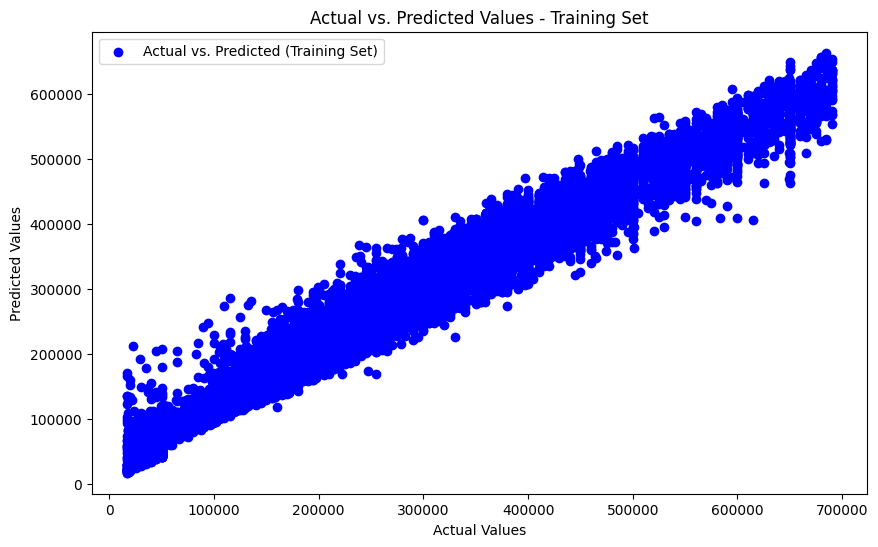

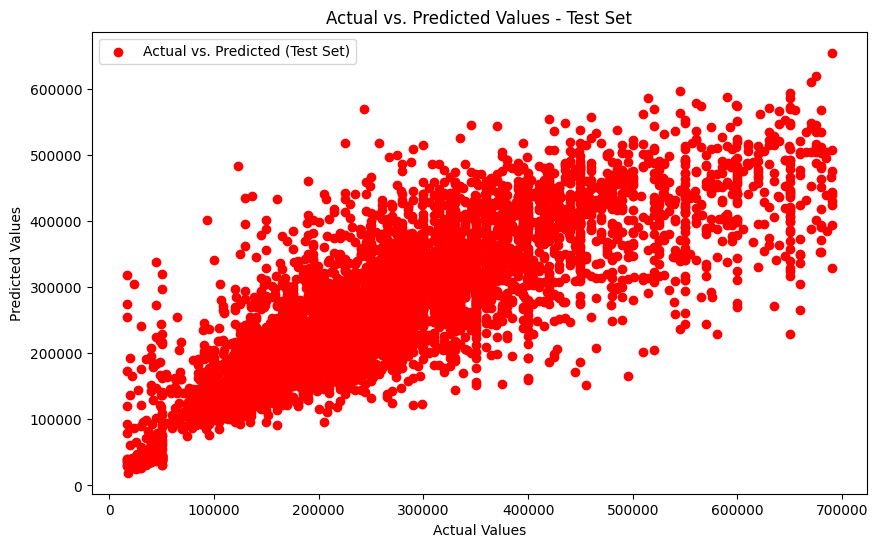

In [246]:
# Scatter plot for Training Set
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='Actual vs. Predicted (Training Set)')
plt.title('Actual vs. Predicted Values - Training Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Scatter plot for Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='red', label='Actual vs. Predicted (Test Set)')
plt.title('Actual vs. Predicted Values - Test Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

## Visualize scores of algorithms

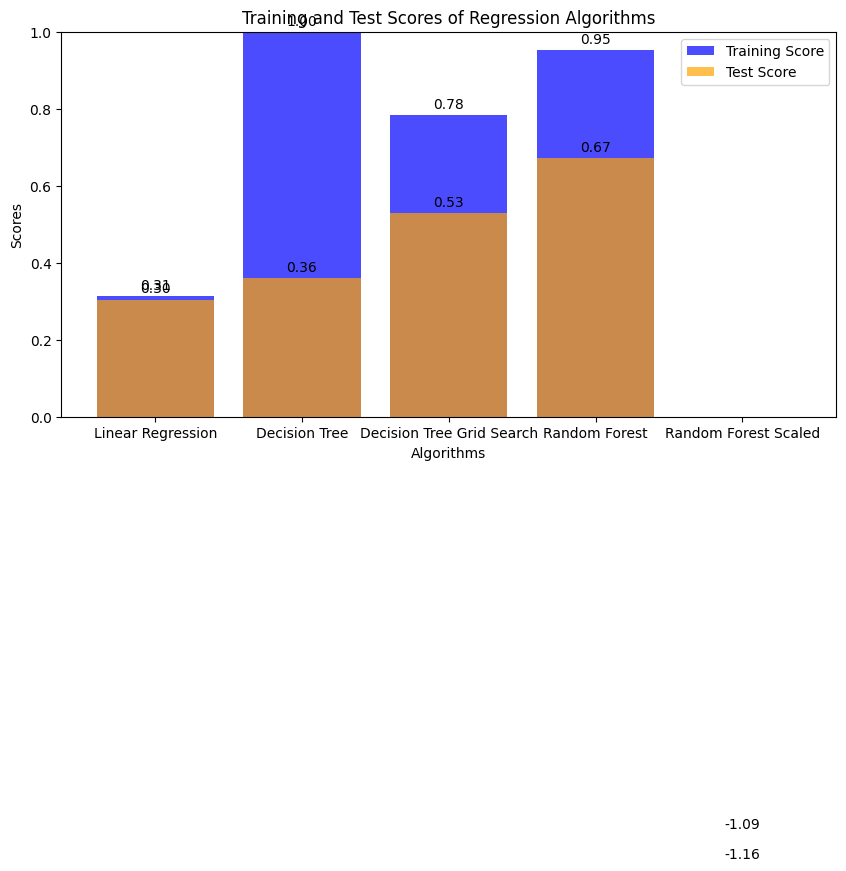

In [248]:
# Extract data from the tuple
train_scores, test_scores, algorithms = zip(*pred_results)

# Create a bar plot for training scores
plt.figure(figsize=(10, 5))
plt.bar(algorithms, train_scores, color='blue', alpha=0.7, label='Training Score')

# Add data labels
for i, score in enumerate(train_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

# Create a bar plot for test scores
plt.bar(algorithms, test_scores, color='orange', alpha=0.7, label='Test Score')

# Add data labels
for i, score in enumerate(test_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

# Set plot properties
plt.ylim(0, 1.0)
plt.title('Training and Test Scores of Regression Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Scores')
plt.legend()
plt.show()